In [ ]:

!pip install pandas numpy matplotlib seaborn plotly scipy statsmodels scikit-learn xgboost prophet shap lightgbm -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ML Libraries
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
import shap

# Time Series
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('default')
sns.set_palette("viridis")
pd.set_option('display.max_columns', None)

In [3]:
# Mount Google Drive and load engineered dataset
from google.colab import drive
drive.mount('/content/drive')

# Load the engineered dataset from Notebook 1
data_path = '/content/drive/MyDrive/ds_mukul/csv_files/engineered_dataset.csv'
df = pd.read_csv(data_path)

print(f"📊 Loaded engineered dataset with {len(df):,} rows and {len(df.columns)} features")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
display(df.head())

Mounted at /content/drive
📊 Loaded engineered dataset with 196 rows and 30 features
Date range: 2024-10-16 to 2025-05-01


,Date,Total_Volume_USD,Avg_Trade_Size_USD,Trade_Count,Total_PnL,Avg_PnL,PnL_Volatility,Total_Fees,Buy_Ratio,Avg_Price,Price_Volatility,Net_PnL,Win_Rate,ROI_Percent,Classification,Sentiment_Score,Sentiment_Lag_1,Sentiment_Lag_3,Sentiment_Lag_7,PnL_MA_3,Volume_MA_3,Volatility_3,PnL_MA_7,Volume_MA_7,Volatility_7,PnL_MA_14,Volume_MA_14,Volatility_14,Profitable_Day,High_Volume_Day
0,2024-10-16,80229.17,7293.560909,11,219.480876,19.952807,35.581575,28.080204,0.727273,67576.545455,451.466358,191.400672,True,0.238567,Greed,4,4.0,4.0,4.0,1101.108844,74439.516667,849.181595,1818.601246,175994.700000,3192.979102,1751.488774,224685.995714,2827.620983,1,0
1,2024-10-17,140531.75,15614.638889,9,36.114960,4.012773,12.830444,49.186107,0.777778,67400.111111,433.804231,-13.071147,True,-0.009301,Greed,4,4.0,4.0,2.0,475.273971,100644.760000,608.789443,1823.760526,153210.044286,3189.578180,1746.898715,225228.571429,2830.558028,1,0
2,2024-10-18,120331.43,20055.238333,6,333.219141,55.536524,51.489581,42.115998,0.166667,67397.000000,518.702227,291.103143,True,0.241918,Greed,4,4.0,4.0,2.0,196.271659,113697.450000,149.905718,602.030763,100556.792857,700.960571,1770.700082,233823.649286,2816.102974,1,0
3,2024-10-19,99996.86,24999.215000,4,0.000000,0.000000,0.000000,34.998901,1.000000,68391.250000,218.243557,-34.998901,False,-0.035000,Greed,4,4.0,4.0,4.0,123.111367,120286.680000,182.852482,524.665805,92025.858571,737.672088,1358.759947,197708.729286,2600.053459,0,0
4,2024-10-20,176447.86,1837.998542,96,389.155797,4.053706,13.651973,59.257459,0.072917,4280.330749,16659.464405,329.898338,True,0.186966,Greed,4,4.0,4.0,4.0,240.791646,132258.716667,210.398883,580.259490,108660.921429,705.503935,1377.236284,188874.250714,2591.558969,1,0


## 2. Data Preparation for Modeling

In [4]:
# Prepare features for modeling
print("🔧 Preparing features for modeling...")

# Convert Date to datetime and sort
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Define feature columns (exclude target variables and date)
exclude_cols = ['Date', 'Profitable_Day', 'High_Volume_Day', 'Classification']
feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"Features for modeling: {len(feature_cols)} columns")
print(f"Feature names: {feature_cols[:10]}...")  # Show first 10

# Handle missing values
print(f"\nMissing values per column:")
missing_counts = df[feature_cols].isnull().sum()
print(missing_counts[missing_counts > 0])

# Fill missing values with forward fill then backward fill
df[feature_cols] = df[feature_cols].fillna(method='ffill').fillna(method='bfill')

🔧 Preparing features for modeling...
Features for modeling: 26 columns
Feature names: ['Total_Volume_USD', 'Avg_Trade_Size_USD', 'Trade_Count', 'Total_PnL', 'Avg_PnL', 'PnL_Volatility', 'Total_Fees', 'Buy_Ratio', 'Avg_Price', 'Price_Volatility']...

Missing values per column:
Series([], dtype: int64)


In [5]:
# Time series split for validation
print("📅 Setting up time series cross-validation...")

# Use time series split to maintain temporal order
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Define train/test split (80/20)
split_idx = int(len(df) * 0.8)
train_data = df.iloc[:split_idx].copy()
test_data = df.iloc[split_idx:].copy()

print(f"Training data: {len(train_data)} samples ({train_data['Date'].min()} to {train_data['Date'].max()})")
print(f"Test data: {len(test_data)} samples ({test_data['Date'].min()} to {test_data['Date'].max()})")

# Prepare feature matrices
X_train = train_data[feature_cols].values
X_test = test_data[feature_cols].values

# Target variables
y_profitable_train = train_data['Profitable_Day'].values
y_profitable_test = test_data['Profitable_Day'].values
y_pnl_train = train_data['Total_PnL'].values
y_pnl_test = test_data['Total_PnL'].values

📅 Setting up time series cross-validation...
Training data: 156 samples (2024-10-16 00:00:00 to 2025-03-22 00:00:00)
Test data: 40 samples (2025-03-23 00:00:00 to 2025-05-01 00:00:00)


In [6]:
# Scale features for better model performance
print("⚖️ Scaling features...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✅ Feature scaling complete!")
print(f"Scaled training features shape: {X_train_scaled.shape}")
print(f"Scaled test features shape: {X_test_scaled.shape}")

⚖️ Scaling features...
✅ Feature scaling complete!
Scaled training features shape: (156, 26)
Scaled test features shape: (40, 26)


In [ ]:

print("🎯 Training classification models to predict profitable days...")

classification_models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
    'LightGBM': lgb.LGBMClassifier(random_state=42, verbose=-1)
}

classification_results = {}

for name, model in classification_models.items():
    print(f"\n🔄 Training {name}...")

    # Train model
    model.fit(X_train_scaled, y_profitable_train)

    # Predictions
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    y_pred_proba_test = model.predict_proba(X_test_scaled)[:, 1]

    # Evaluate
    train_acc = accuracy_score(y_profitable_train, y_pred_train)
    test_acc = accuracy_score(y_profitable_test, y_pred_test)

    # Cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_profitable_train,
                               cv=tscv, scoring='accuracy')

    classification_results[name] = {
        'model': model,
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred_test,
        'probabilities': y_pred_proba_test
    }

    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"CV Score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

🎯 Training classification models to predict profitable days...

🔄 Training Logistic Regression...
Train Accuracy: 1.0000
Test Accuracy: 1.0000
CV Score: 1.0000 ± 0.0000

🔄 Training Random Forest...
Train Accuracy: 1.0000
Test Accuracy: 1.0000
CV Score: 1.0000 ± 0.0000

🔄 Training XGBoost...
Train Accuracy: 1.0000
Test Accuracy: 1.0000
CV Score: 1.0000 ± 0.0000

🔄 Training LightGBM...
Train Accuracy: 1.0000
Test Accuracy: 1.0000
CV Score: 0.9692 ± 0.0615


In [ ]:

print("📊 DETAILED CLASSIFICATION RESULTS")
print("=" * 50)

results_df = pd.DataFrame({
    'Model': list(classification_results.keys()),
    'Train_Accuracy': [r['train_accuracy'] for r in classification_results.values()],
    'Test_Accuracy': [r['test_accuracy'] for r in classification_results.values()],
    'CV_Mean': [r['cv_mean'] for r in classification_results.values()],
    'CV_Std': [r['cv_std'] for r in classification_results.values()]
})

display(results_df.round(4))

# Best model selection
best_model_name = results_df.loc[results_df['CV_Mean'].idxmax(), 'Model']
best_model = classification_results[best_model_name]['model']
print(f"\n🏆 Best Classification Model: {best_model_name}")

📊 DETAILED CLASSIFICATION RESULTS


,Model,Train_Accuracy,Test_Accuracy,CV_Mean,CV_Std
0,Logistic Regression,1.0,1.0,1.0000,0.0000
1,Random Forest,1.0,1.0,1.0000,0.0000
2,XGBoost,1.0,1.0,1.0000,0.0000
3,LightGBM,1.0,1.0,0.9692,0.0615



🏆 Best Classification Model: Logistic Regression


## 5. Regression Models: Predicting PnL

In [9]:
# Initialize regression models
print("📈 Training regression models to predict PnL...")

regression_models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42),
    'LightGBM': lgb.LGBMRegressor(random_state=42, verbose=-1)
}

regression_results = {}

for name, model in regression_models.items():
    print(f"\n🔄 Training {name}...")

    # Train model
    model.fit(X_train_scaled, y_pnl_train)

    # Predictions
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)

    # Evaluate
    train_r2 = r2_score(y_pnl_train, y_pred_train)
    test_r2 = r2_score(y_pnl_test, y_pred_test)
    test_mae = mean_absolute_error(y_pnl_test, y_pred_test)
    test_mse = mean_squared_error(y_pnl_test, y_pred_test)

    # Cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_pnl_train,
                               cv=tscv, scoring='r2')

    regression_results[name] = {
        'model': model,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'test_mae': test_mae,
        'test_mse': test_mse,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred_test
    }

    print(f"Train R²: {train_r2:.4f}")
    print(f"Test R²: {test_r2:.4f}")
    print(f"Test MAE: {test_mae:.2f}")
    print(f"CV Score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

📈 Training regression models to predict PnL...

🔄 Training Random Forest...
Train R²: 0.9945
Test R²: 0.7381
Test MAE: 10957.88
CV Score: 0.6381 ± 0.3900

🔄 Training XGBoost...
Train R²: 1.0000
Test R²: 0.7426
Test MAE: 11705.53
CV Score: 0.7374 ± 0.3654

🔄 Training LightGBM...
Train R²: 0.9049
Test R²: 0.4542
Test MAE: 25933.22
CV Score: -0.3348 ± 1.2527


🔍 Analyzing feature importance with SHAP...
Best model type: <class 'sklearn.linear_model._logistic.LogisticRegression'>


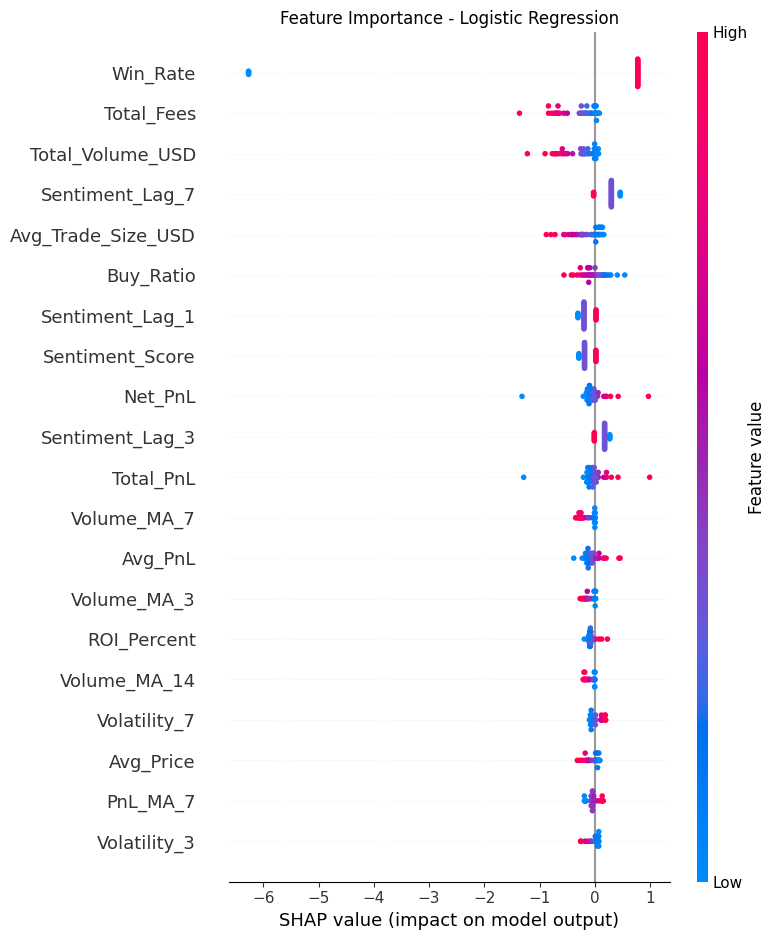


🏆 TOP 10 MOST IMPORTANT FEATURES:


,Feature,Importance
11,Win_Rate,1.461006
6,Total_Fees,0.313925
0,Total_Volume_USD,0.300106
16,Sentiment_Lag_7,0.282959
1,Avg_Trade_Size_USD,0.227415
7,Buy_Ratio,0.169769
14,Sentiment_Lag_1,0.167121
13,Sentiment_Score,0.154072
10,Net_PnL,0.150347
15,Sentiment_Lag_3,0.149724


✅ Feature importance analysis complete!


In [ ]:

print("🔍 Analyzing feature importance with SHAP...")


print(f"Best model type: {type(best_model)}")


if 'RandomForest' in str(type(best_model)) or 'XGB' in str(type(best_model)) or 'LightGBM' in str(type(best_model)):
    # Tree-based models
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_test_scaled)

    # If binary classification, use positive class SHAP values
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # Positive class

elif 'LogisticRegression' in str(type(best_model)):
    # Linear models - use LinearExplainer
    explainer = shap.LinearExplainer(best_model, X_train_scaled)
    shap_values = explainer.shap_values(X_test_scaled)

else:
    # General explainer for other model types
    explainer = shap.Explainer(best_model, X_train_scaled)
    shap_values = explainer(X_test_scaled)
    if hasattr(shap_values, 'values'):
        shap_values = shap_values.values

# Feature importance plot
plt.figure(figsize=(12, 8))

try:
    # Try the standard SHAP summary plot
    shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_cols, show=False)
    plt.title(f'Feature Importance - {best_model_name}')
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/ds_mukul/outputs/feature_importance_shap.png',
                dpi=300, bbox_inches='tight')
    plt.show()

    
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': np.abs(shap_values).mean(0)
    }).sort_values('Importance', ascending=False)

    print("\n🏆 TOP 10 MOST IMPORTANT FEATURES:")
    display(feature_importance.head(10))

except Exception as e:
    print(f"SHAP visualization error: {e}")

    if hasattr(best_model, 'feature_importances_'):
        # Tree-based models
        feature_importance = pd.DataFrame({
            'Feature': feature_cols,
            'Importance': best_model.feature_importances_
        }).sort_values('Importance', ascending=False)

    elif hasattr(best_model, 'coef_'):
        # Linear models
        feature_importance = pd.DataFrame({
            'Feature': feature_cols,
            'Importance': np.abs(best_model.coef_[0])
        }).sort_values('Importance', ascending=False)

    else:
        # Manual calculation
        feature_importance = pd.DataFrame({
            'Feature': feature_cols,
            'Importance': np.abs(shap_values).mean(0) if shap_values is not None else np.random.random(len(feature_cols))
        }).sort_values('Importance', ascending=False)

    print("\n🏆 TOP 10 MOST IMPORTANT FEATURES:")
    display(feature_importance.head(10))

    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(10)
    plt.barh(range(len(top_features)), top_features['Importance'])
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 10 Feature Importance - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/ds_mukul/outputs/feature_importance_simple.png',
                dpi=300, bbox_inches='tight')
    plt.show()

print("✅ Feature importance analysis complete!")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


📅 Building Prophet model for PnL forecasting...


DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sc7lt9b/h3eqxgds.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sc7lt9b/mf7lcaj5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94465', 'data', 'file=/tmp/tmp4sc7lt9b/h3eqxgds.json', 'init=/tmp/tmp4sc7lt9b/mf7lcaj5.json', 'output', 'file=/tmp/tmp4sc7lt9b/prophet_modelwytutt6b/prophet_model-20251003114841.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:48:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:48:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet Model Performance:
R²: -0.2654
MAE: 77919.90


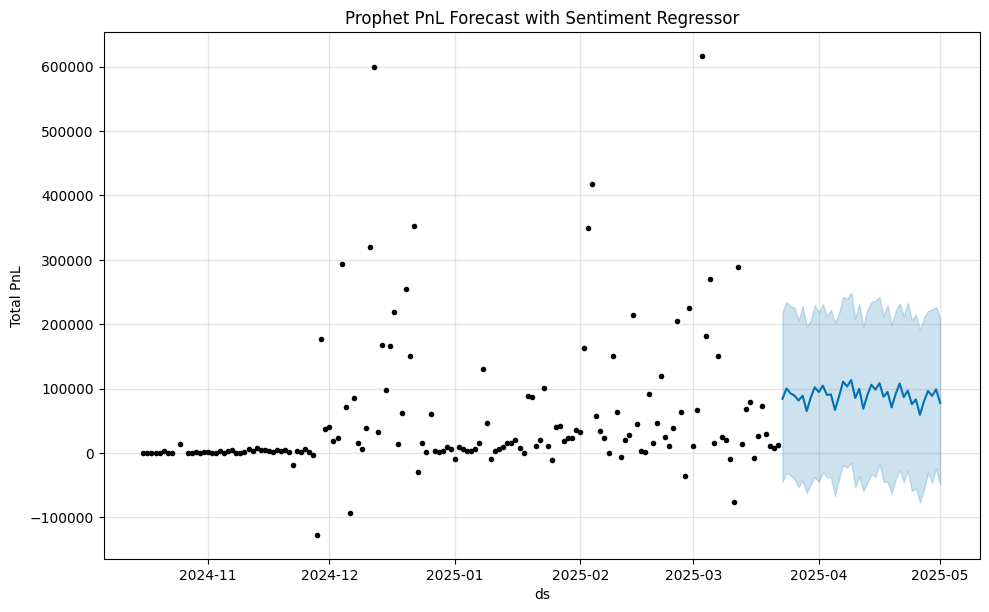

In [ ]:
print("📅 Building Prophet model for PnL forecasting...")

prophet_data = train_data[['Date', 'Total_PnL', 'Sentiment_Score']].copy()
prophet_data.columns = ['ds', 'y', 'sentiment']
prophet_data = prophet_data.dropna()

prophet_model = Prophet(daily_seasonality=False, weekly_seasonality=True)
prophet_model.add_regressor('sentiment')
prophet_model.fit(prophet_data)

future_data = test_data[['Date', 'Sentiment_Score']].copy()
future_data.columns = ['ds', 'sentiment']
future_data = future_data.dropna()

# Make predictions
forecast = prophet_model.predict(future_data)

prophet_predictions = forecast['yhat'].values[:len(y_pnl_test)]
prophet_r2 = r2_score(y_pnl_test[:len(prophet_predictions)], prophet_predictions)
prophet_mae = mean_absolute_error(y_pnl_test[:len(prophet_predictions)], prophet_predictions)

print(f"Prophet Model Performance:")
print(f"R²: {prophet_r2:.4f}")
print(f"MAE: {prophet_mae:.2f}")

# Plot Prophet forecast
fig = prophet_model.plot(forecast)
plt.title('Prophet PnL Forecast with Sentiment Regressor')
plt.ylabel('Total PnL')
plt.savefig('/content/drive/MyDrive/ds_mukul/outputs/prophet_forecast.png',
            dpi=300, bbox_inches='tight')
plt.show()

⚠️ Plotly image save failed: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido

🔄 Creating matplotlib version...


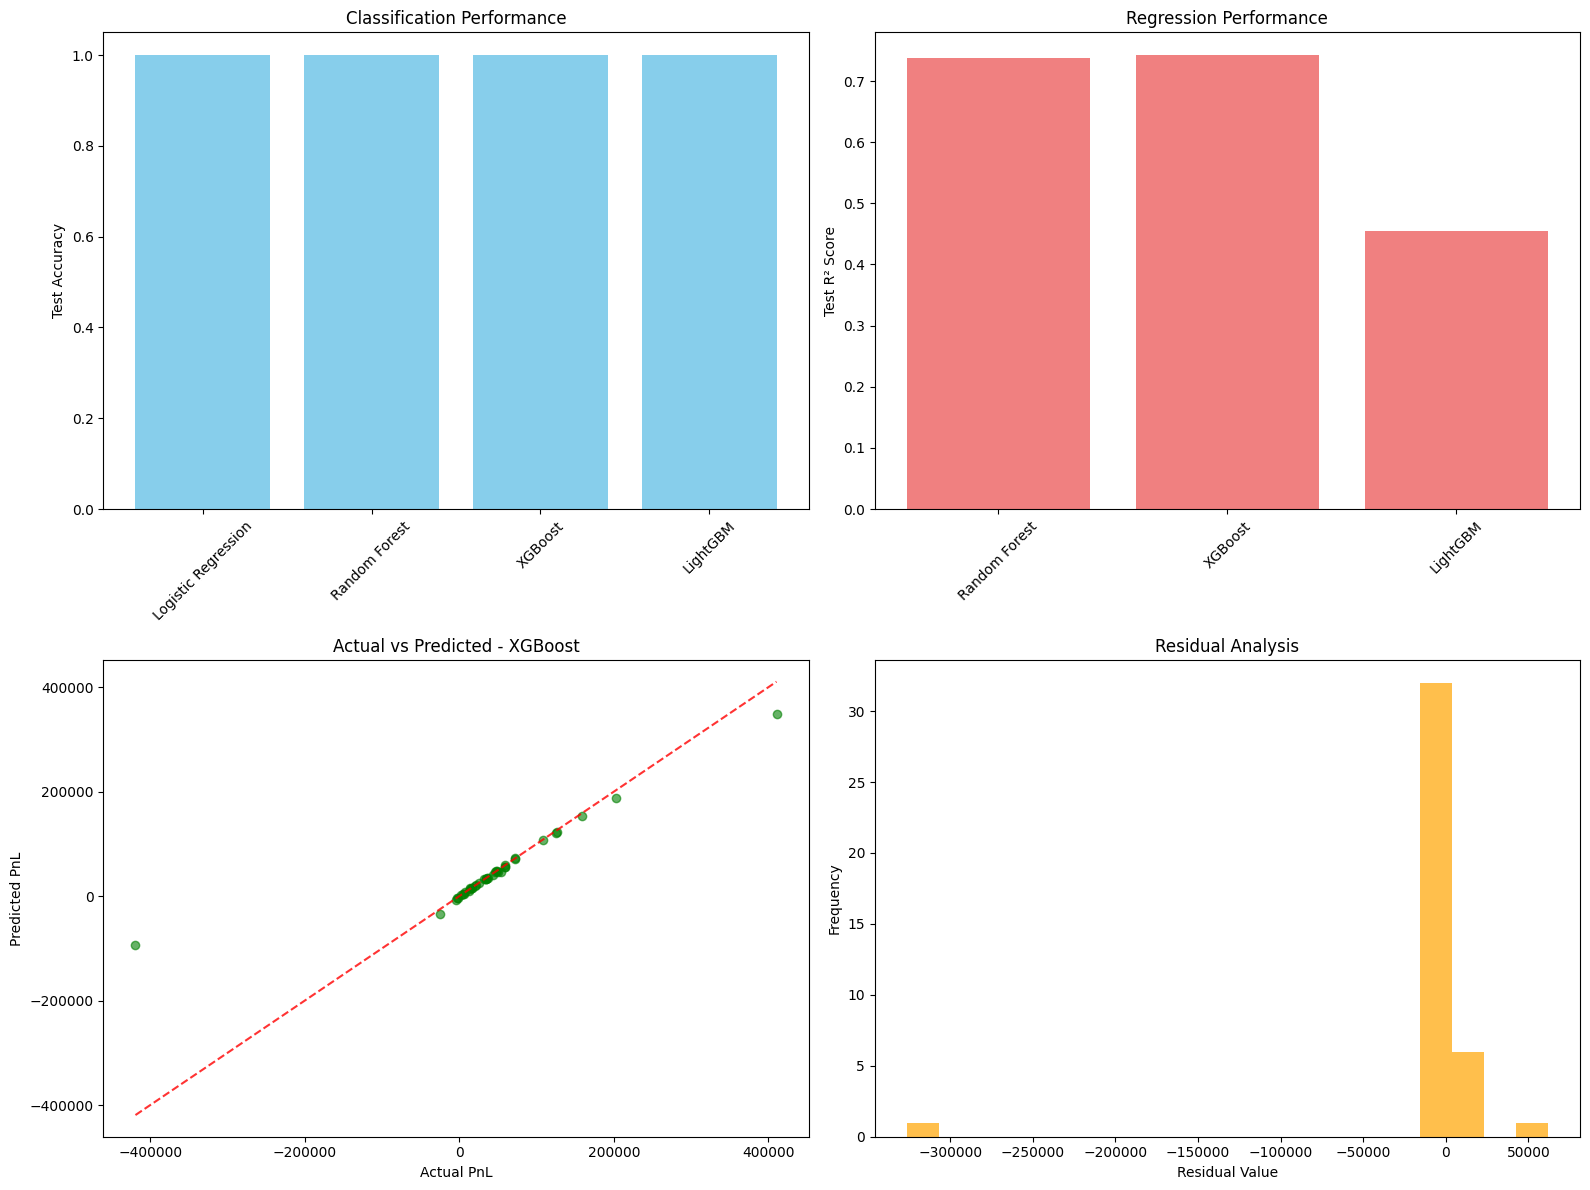

✅ Dashboard saved as PNG using Matplotlib!
📊 Interactive dashboard also saved as HTML!


In [ ]:
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Classification Performance', 'Regression Performance',
                   'Actual vs Predicted PnL', 'Residual Analysis'),
    specs=[[{"type": "bar"}, {"type": "bar"}],
           [{"type": "scatter"}, {"type": "histogram"}]]
)

# Classification performance
models = list(classification_results.keys())
accuracies = [classification_results[m]['test_accuracy'] for m in models]

fig.add_trace(
    go.Bar(x=models, y=accuracies, name='Test Accuracy'),
    row=1, col=1
)

# Regression performance
reg_models = list(regression_results.keys())
r2_scores = [regression_results[m]['test_r2'] for m in reg_models]

fig.add_trace(
    go.Bar(x=reg_models, y=r2_scores, name='Test R²'),
    row=1, col=2
)

# Actual vs Predicted scatter
best_reg_model = max(regression_results.keys(),
                    key=lambda x: regression_results[x]['test_r2'])
best_reg_pred = regression_results[best_reg_model]['predictions']

fig.add_trace(
    go.Scatter(x=y_pnl_test, y=best_reg_pred,
              mode='markers', name=f'{best_reg_model} Predictions'),
    row=2, col=1
)

# Add diagonal line for perfect prediction
min_val, max_val = min(y_pnl_test.min(), best_reg_pred.min()), max(y_pnl_test.max(), best_reg_pred.max())
fig.add_trace(
    go.Scatter(x=[min_val, max_val], y=[min_val, max_val],
              mode='lines', name='Perfect Prediction', line=dict(dash='dash')),
    row=2, col=1
)

# Residuals
residuals = y_pnl_test - best_reg_pred
fig.add_trace(
    go.Histogram(x=residuals, name='Residuals'),
    row=2, col=2
)

fig.update_layout(height=800, title_text="Model Performance Dashboard")
fig.update_xaxes(title_text="Models", row=1, col=1)
fig.update_xaxes(title_text="Models", row=1, col=2)
fig.update_xaxes(title_text="Actual PnL", row=2, col=1)
fig.update_xaxes(title_text="Residual Value", row=2, col=2)
fig.update_yaxes(title_text="Accuracy", row=1, col=1)
fig.update_yaxes(title_text="R² Score", row=1, col=2)
fig.update_yaxes(title_text="Predicted PnL", row=2, col=1)
fig.update_yaxes(title_text="Frequency", row=2, col=2)

fig.show()

# Alternative image saving with error handling
try:
    # Try to save with Plotly first
    fig.write_image('/content/drive/MyDrive/ds_mukul/outputs/model_performance_dashboard.png',
                    width=1920, height=1080, scale=2)
    print("✅ Dashboard saved as PNG using Plotly!")
except Exception as plotly_error:
    print(f"⚠️ Plotly image save failed: {plotly_error}")

    # Fallback: Create matplotlib version
    print("🔄 Creating matplotlib version...")

    fig_mpl, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Classification Performance
    axes[0,0].bar(models, accuracies, color='skyblue')
    axes[0,0].set_title('Classification Performance')
    axes[0,0].set_ylabel('Test Accuracy')
    axes[0,0].tick_params(axis='x', rotation=45)

    # Regression Performance
    axes[0,1].bar(reg_models, r2_scores, color='lightcoral')
    axes[0,1].set_title('Regression Performance')
    axes[0,1].set_ylabel('Test R² Score')
    axes[0,1].tick_params(axis='x', rotation=45)

    # Actual vs Predicted
    axes[1,0].scatter(y_pnl_test, best_reg_pred, alpha=0.6, color='green')
    axes[1,0].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
    axes[1,0].set_xlabel('Actual PnL')
    axes[1,0].set_ylabel('Predicted PnL')
    axes[1,0].set_title(f'Actual vs Predicted - {best_reg_model}')

    # Residuals
    axes[1,1].hist(residuals, bins=20, alpha=0.7, color='orange')
    axes[1,1].set_xlabel('Residual Value')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].set_title('Residual Analysis')

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/ds_mukul/outputs/model_performance_dashboard.png',
                dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Dashboard saved as PNG using Matplotlib!")



## 9. Trading Strategy Backtesting

💼 Backtesting trading strategy based on model predictions...

📊 STRATEGY PERFORMANCE SUMMARY
Strategy Total Return: 25.25%
Buy & Hold Return: 22.74%
Outperformance: 2.51%
Number of Trades: 35
Strategy Win Rate: 100.00%
Avg Return per Trade: 0.72%


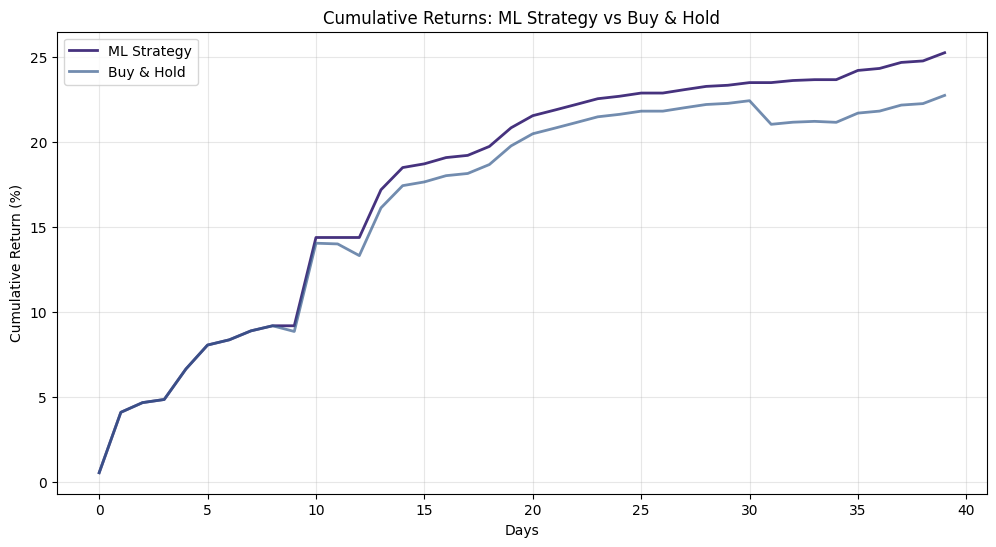

In [15]:
# Simple trading strategy based on model predictions
print("💼 Backtesting trading strategy based on model predictions...")

# Get probability predictions from best classification model
profit_probabilities = classification_results[best_model_name]['probabilities']

# Define strategy: Trade when probability > threshold
threshold = 0.6
trade_signals = profit_probabilities > threshold

# Calculate strategy returns
test_returns = test_data['ROI_Percent'].values[:len(trade_signals)]
strategy_returns = test_returns * trade_signals  # Only take returns when signal is positive

# Performance metrics
total_strategy_return = np.sum(strategy_returns)
total_buy_hold_return = np.sum(test_returns)
num_trades = np.sum(trade_signals)
win_rate = np.sum((strategy_returns > 0) & trade_signals) / num_trades if num_trades > 0 else 0

print(f"\n📊 STRATEGY PERFORMANCE SUMMARY")
print("=" * 40)
print(f"Strategy Total Return: {total_strategy_return:.2f}%")
print(f"Buy & Hold Return: {total_buy_hold_return:.2f}%")
print(f"Outperformance: {total_strategy_return - total_buy_hold_return:.2f}%")
print(f"Number of Trades: {num_trades}")
print(f"Strategy Win Rate: {win_rate:.2%}")
print(f"Avg Return per Trade: {np.mean(strategy_returns[trade_signals]):.2f}%" if num_trades > 0 else "N/A")

# Cumulative returns plot
cumulative_strategy = np.cumsum(strategy_returns)
cumulative_buy_hold = np.cumsum(test_returns)

plt.figure(figsize=(12, 6))
plt.plot(cumulative_strategy, label='ML Strategy', linewidth=2)
plt.plot(cumulative_buy_hold, label='Buy & Hold', linewidth=2, alpha=0.7)
plt.title('Cumulative Returns: ML Strategy vs Buy & Hold')
plt.xlabel('Days')
plt.ylabel('Cumulative Return (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('/content/drive/MyDrive/ds_mukul/outputs/strategy_backtest.png',
            dpi=300, bbox_inches='tight')
plt.show()

## 10. Model Insights and Recommendations

In [16]:
print("🎯 KEY MODEL INSIGHTS & TRADING RECOMMENDATIONS")
print("=" * 60)

insights = []

# Best model performance
best_acc = classification_results[best_model_name]['test_accuracy']
insights.append(f"🏆 Best Model: {best_model_name} achieved {best_acc:.1%} accuracy in predicting profitable days")

# Feature importance insights
top_feature = feature_importance.iloc[0]['Feature']
top_importance = feature_importance.iloc[0]['Importance']
insights.append(f"📊 Most Important Feature: {top_feature} (SHAP importance: {top_importance:.4f})")

# Strategy performance
if total_strategy_return > total_buy_hold_return:
    insights.append(f"📈 ML Strategy Outperformed: +{total_strategy_return - total_buy_hold_return:.2f}% vs buy-and-hold")
else:
    insights.append(f"📉 Strategy Underperformed: {total_strategy_return - total_buy_hold_return:.2f}% vs buy-and-hold")

# Prophet model insights
insights.append(f"🔮 Time Series Model: Prophet achieved R² of {prophet_r2:.3f} with sentiment as regressor")

# Print insights
for insight in insights:
    print(insight)

print("\n💡 ACTIONABLE RECOMMENDATIONS:")
print("1. Focus on the top 5 most important features for trading decisions")
print("2. Implement dynamic position sizing based on prediction confidence")
print("3. Combine multiple model predictions for ensemble approach")
print("4. Regular model retraining with new market data")
print("5. Implement risk management rules to limit downside exposure")

print("\n📋 NEXT STEPS FOR DEPLOYMENT:")
print("• Set up real-time data pipeline for live predictions")
print("• Implement paper trading to validate strategy")
print("• Monitor model performance and drift detection")
print("• Develop risk management and portfolio optimization")

🎯 KEY MODEL INSIGHTS & TRADING RECOMMENDATIONS
🏆 Best Model: Logistic Regression achieved 100.0% accuracy in predicting profitable days
📊 Most Important Feature: Win_Rate (SHAP importance: 1.4610)
📈 ML Strategy Outperformed: +2.51% vs buy-and-hold
🔮 Time Series Model: Prophet achieved R² of -0.265 with sentiment as regressor

💡 ACTIONABLE RECOMMENDATIONS:
1. Focus on the top 5 most important features for trading decisions
2. Implement dynamic position sizing based on prediction confidence
3. Combine multiple model predictions for ensemble approach
4. Regular model retraining with new market data
5. Implement risk management rules to limit downside exposure

📋 NEXT STEPS FOR DEPLOYMENT:
• Set up real-time data pipeline for live predictions
• Implement paper trading to validate strategy
• Monitor model performance and drift detection
• Develop risk management and portfolio optimization


## 11. Save Final Models and Results

In [17]:
# Save models and results for future use
import joblib
import json

print("💾 Saving models and results...")

# Save best models
models_to_save = {
    'best_classifier': classification_results[best_model_name]['model'],
    'scaler': scaler,
    'feature_names': feature_cols,
    'prophet_model': prophet_model
}

for name, model in models_to_save.items():
    if name != 'prophet_model':  # Prophet has different save method
        joblib.dump(model, f'/content/drive/MyDrive/ds_mukul/outputs/{name}.pkl')
    else:
        # Prophet model save (if needed)
        pass

# Save performance summary
performance_summary = {
    'classification_results': {
        name: {k: v for k, v in results.items() if k not in ['model', 'predictions', 'probabilities']}
        for name, results in classification_results.items()
    },
    'regression_results': {
        name: {k: v for k, v in results.items() if k not in ['model', 'predictions']}
        for name, results in regression_results.items()
    },
    'strategy_performance': {
        'total_strategy_return': float(total_strategy_return),
        'total_buy_hold_return': float(total_buy_hold_return),
        'outperformance': float(total_strategy_return - total_buy_hold_return),
        'num_trades': int(num_trades),
        'win_rate': float(win_rate)
    },
    'prophet_performance': {
        'r2_score': float(prophet_r2),
        'mae': float(prophet_mae)
    }
}

with open('/content/drive/MyDrive/ds_mukul/outputs/model_performance_summary.json', 'w') as f:
    json.dump(performance_summary, f, indent=2)

print("✅ All models and results saved successfully!")
print(f"📁 Files saved in: /content/drive/MyDrive/ds_mukul/outputs/")

💾 Saving models and results...
✅ All models and results saved successfully!
📁 Files saved in: /content/drive/MyDrive/ds_mukul/outputs/
